In [19]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings("ignore")

WEATHER_FILE = "../data/raw/processed_municipality_combined.csv"
PRICES_FILE = "../data/raw/prices.csv"
EMISSIONS_FILE = "../data/raw/emissions.csv"

OUTPUT_DIR = "../results/national"

MAX_SIMULATION_DAYS = 1_000
HEATING_MONTHS = [
    1,
    2,
    3,
    4,
    10,
    11,
    12,
]  # Heating season months (Oct-Apr and filter out summer months)

# Simulation parameters
COP_ELECTRIC = 1.0  # Electric heaters: 1 kWh electricity -> 1 kWh heat
COP_HEATPUMP = 3.0  # Heat pumps: 1 kWh electricity -> 3 kWh heat
T_SETPOINT = 21.0  # Hysteresis setpoint (°C)
T_COMFORT_MIN = 20.0  # DP comfort band: min temperature
T_COMFORT_MAX = 23.0  # DP comfort band: max temperature
P_HEAT_KW = 5.0  # Thermal output power (kW)

HEATING_DAYS_PER_YEAR = 180

# Data and Models 

In [20]:
@dataclass
class ThermalParams:
    """Physical parameters of the thermal system."""

    h: float  # Heat loss coefficient (kW/°C)
    C: float  # Thermal capacitance (kWh/°C)
    P_heat: float  # Thermal output power (kW)
    COP: float  # Coefficient of Performance

    @property
    def P_elec(self) -> float:
        """Electrical power consumption (kW)."""
        return self.P_heat / self.COP

    @property
    def tau(self) -> float:
        """Time constant in hours."""
        return self.C / self.h if self.h > 0 else 100.0


@dataclass
class BuildingArchetype:
    key: str
    name: str
    period_start: int
    period_end: int
    tau_hours: float
    typical_area_m2: float


# Typical area is defined in TABULA Report
# Tau (time constant) is defined in "Bygninger som energilager i et smart grid"
ARCHETYPES = [
    BuildingArchetype("pre_1930", "Pre-1930", 0, 1929, 44.0, 112),
    BuildingArchetype("1930_1950", "1930-1950", 1930, 1950, 32.4, 140),  # Not listed
    BuildingArchetype("1951_1960", "1951-1960", 1951, 1960, 38.0, 106),
    BuildingArchetype("1961_1972", "1961-1972", 1961, 1972, 50.0, 180),
    BuildingArchetype("1973_1978", "1973-1978", 1973, 1978, 40.0, 138),
    BuildingArchetype("1979_1998", "1979-1998", 1979, 1998, 46.0, 143),
    BuildingArchetype("1999_2006", "1999-2006", 1999, 2006, 55.0, 175),  # Not listed
    BuildingArchetype("post_2006", "Post-2006", 2007, 2100, 70.0, 171),  # Not listed
]

# From Danmarks Statistik
BUILDING_STOCK_RAW = [
    ("Før 1900", 1850, 1899, 10267, 19767),
    ("1900-1904", 1900, 1904, 2827, 6776),
    ("1905-1909", 1905, 1909, 1021, 3201),
    ("1910-1914", 1910, 1914, 1237, 4063),
    ("1915-1919", 1915, 1919, 722, 2434),
    ("1920-1924", 1920, 1924, 1084, 3633),
    ("1925-1929", 1925, 1929, 1172, 4231),
    ("1930-1934", 1930, 1934, 1126, 4500),
    ("1935-1939", 1935, 1939, 1052, 4462),
    ("1940-1944", 1940, 1944, 716, 2469),
    ("1945-1949", 1945, 1949, 895, 3247),
    ("1950-1954", 1950, 1954, 1103, 4560),
    ("1955-1959", 1955, 1959, 1337, 4741),
    ("1960-1964", 1960, 1964, 2610, 8272),
    ("1965-1969", 1965, 1969, 2385, 10567),
    ("1970-1974", 1970, 1974, 6922, 11957),
    ("1975-1979", 1975, 1979, 11271, 8896),
    ("1980-1984", 1980, 1984, 7351, 3702),
    ("1985-1989", 1985, 1989, 6874, 2821),
    ("1990-1994", 1990, 1994, 1164, 904),
    ("1995-1999", 1995, 1999, 666, 2346),
    ("2000-2004", 2000, 2004, 571, 3549),
    ("2005-2009", 2005, 2009, 469, 6177),
    ("2010-2014", 2010, 2014, 109, 5737),
    ("2015-2019", 2015, 2019, 67, 7633),
    ("2020-", 2020, 2025, 82, 11046),
]

In [21]:
def get_building_counts_by_archetype() -> Dict[str, Tuple[int, int]]:
    counts = {arch.key: [0, 0] for arch in ARCHETYPES}

    for _, year_start, year_end, electric, heatpump in BUILDING_STOCK_RAW:
        year_mid = (year_start + year_end) / 2

        # Find matching archetype
        for arch in ARCHETYPES:
            if arch.period_start <= year_mid <= arch.period_end:
                counts[arch.key][0] += electric
                counts[arch.key][1] += heatpump
                break

    return {k: tuple(v) for k, v in counts.items()}


get_building_counts_by_archetype()

{'pre_1930': (18330, 44105),
 '1930_1950': (3789, 14678),
 '1951_1960': (2440, 9301),
 '1961_1972': (11917, 30796),
 '1973_1978': (11271, 8896),
 '1979_1998': (16055, 9773),
 '1999_2006': (571, 3549),
 'post_2006': (727, 30593)}

In [22]:
def create_thermal_params(
    tau_hours: float, area_m2: float, COP: float, power_kw: float
) -> ThermalParams:
    """Create thermal parameters from time constant and area."""
    C_specific = 0.1  # kWh/(°C·m²) - thermal mass per unit area (from TABULA Report)
    C = C_specific * area_m2
    h = C / tau_hours
    return ThermalParams(h=h, C=C, P_heat=power_kw, COP=COP)


# Example from the results of the field experiment
create_thermal_params(tau_hours=13.1, area_m2=10, COP=1.0, power_kw=0.44)

ThermalParams(h=0.07633587786259542, C=1.0, P_heat=0.44, COP=1.0)

# Data Loading and Merging

In [23]:
def load_weather_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath)
    df["datetime_dk"] = pd.to_datetime(df["datetime_dk"])
    df["date"] = df["datetime_dk"].dt.date
    df["month"] = df["datetime_dk"].dt.month
    df["hour"] = df["datetime_dk"].dt.hour
    return df


def load_prices_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, sep=";", decimal=",")
    df["HourDK"] = pd.to_datetime(df["HourDK"])
    df["price_eur_kwh"] = df["SpotPriceEUR"] / 1000  # Convert EUR/MWh to EUR/kWh

    return df


def load_emissions_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, sep=";", decimal=",")
    df["HourDK"] = pd.to_datetime(df["HourDK"])

    # Filter to 125% allocation method
    df = df[df["FuelAllocationMethod"] == "125%"].copy()
    df["co2_g_kwh"] = df["CO2PerkWh"]
    return df


def merge_all_data(
    df_weather: pd.DataFrame, df_prices: pd.DataFrame, df_emissions: pd.DataFrame
) -> pd.DataFrame:
    # Create merge keys (hourly resolution)
    df_weather["merge_key"] = df_weather["datetime_dk"].dt.strftime("%Y-%m-%d %H:00:00")
    df_prices["merge_key"] = df_prices["HourDK"].dt.strftime("%Y-%m-%d %H:00:00")
    df_emissions["merge_key"] = df_emissions["HourDK"].dt.strftime("%Y-%m-%d %H:00:00")

    # Deduplicate
    df_prices_slim = df_prices[["merge_key", "price_eur_kwh"]].drop_duplicates(
        "merge_key"
    )
    df_emissions_slim = df_emissions[["merge_key", "co2_g_kwh"]].drop_duplicates(
        "merge_key"
    )

    df = df_weather.merge(df_prices_slim, on="merge_key", how="inner")
    df = df.merge(df_emissions_slim, on="merge_key", how="left")

    missing_emissions = df["co2_g_kwh"].isna().sum()
    if missing_emissions > 0:
        df = df.dropna(subset=["co2_g_kwh"])

    return df


def prepare_daily_data(
    df: pd.DataFrame,
) -> List[Tuple[np.ndarray, np.ndarray, np.ndarray, str]]:
    # Filter to heating season
    df_heat = df[
        (df["month"].isin(HEATING_MONTHS))
        & (df["temp_mean_past1h"] < 15)
        & (df["temp_mean_past1h"] > -25)
        & (df["price_eur_kwh"] > 0)
    ].copy()

    day_counts = df_heat.groupby("date").size()
    complete_days = day_counts[day_counts >= 24].index.tolist()
    print(f"Found {len(complete_days)} complete days")

    # Sample if needed
    if MAX_SIMULATION_DAYS and len(complete_days) > MAX_SIMULATION_DAYS:
        np.random.seed(42)
        complete_days = list(
            np.random.choice(complete_days, size=MAX_SIMULATION_DAYS, replace=False)
        )
        print(f"Use {MAX_SIMULATION_DAYS} days for simulation (randomly sampled)")

    # Extract daily data
    daily_data = []
    for day in complete_days:
        day_df = df_heat[df_heat["date"] == day].sort_values("hour").head(24)

        if len(day_df) == 24:
            daily_data.append(
                (
                    day_df["temp_mean_past1h"].values.astype(float),
                    day_df["price_eur_kwh"].values.astype(float),
                    day_df["co2_g_kwh"].values.astype(float),
                    str(day),
                )
            )

    return daily_data


# Thermal model (same as in field experiment simulation)

In [24]:
def simulate_thermal_step(
    T_in: float, T_out: float, P_heat: float, params: ThermalParams, dt: float = 0.25
) -> float:
    dT = (P_heat - params.h * (T_in - T_out)) / params.C * dt
    return T_in + dT

# Control Strategies (Hysteresis vs. Dynamic Programming)

In [25]:
def simulate_hysteresis(
    T_outdoor: np.ndarray,
    prices: np.ndarray,
    emissions: np.ndarray,
    params: ThermalParams,
    setpoint: float,
) -> Tuple[float, float, float, np.ndarray]:
    dt = 0.25  # 15-minute steps
    n_steps = 24 * 4  # One day in 15-minute steps

    T_out = np.repeat(T_outdoor, 4)
    prices_15min = np.repeat(prices, 4)
    emissions_15min = np.repeat(emissions, 4)

    T = setpoint  # Start at setpoint
    total_cost = 0.0
    total_elec = 0.0
    total_emissions = 0.0
    hourly_elec = np.zeros(24)  # Track hourly electricity consumption

    for i in range(n_steps):
        # Hysteresis control: ON if below setpoint
        P_heat = params.P_heat if T < setpoint else 0.0

        # Calculate electrical energy consumed
        # IMPORTANT: Electrical energy = Thermal energy / COP
        elec_energy = (P_heat / params.COP) * dt  # kWh

        # Accumulate totals
        total_elec += elec_energy
        total_cost += elec_energy * prices_15min[i]
        total_emissions += elec_energy * emissions_15min[i]
        hourly_elec[i // 4] += elec_energy  # Aggregate to hourly

        # Update temperature
        T = simulate_thermal_step(T, T_out[i], P_heat, params, dt)

    return total_cost, total_elec, total_emissions, hourly_elec


def simulate_dp(
    T_outdoor: np.ndarray,
    prices: np.ndarray,
    emissions: np.ndarray,
    params: ThermalParams,
    setpoint: float,
    T_comfort_min: float,
    T_comfort_max: float,
) -> Tuple[float, float, float, np.ndarray]:
    dt = 0.25
    n_steps = 24 * 4

    # Extend to 15-minute resolution (since this is what the field experiment uses)
    T_out = np.repeat(T_outdoor, 4)
    prices_15min = np.repeat(prices, 4)
    emissions_15min = np.repeat(emissions, 4)

    T_min = T_comfort_min
    T_max = T_comfort_max

    grid_step = 0.1
    grid_pad = 2.0
    penalty_scale = 5000

    grid_min = T_min - grid_pad
    grid_max = T_max + grid_pad
    temps = np.arange(grid_min, grid_max + grid_step, grid_step)
    n_states = len(temps)

    def temp_to_idx(T: float) -> int:
        idx = int(round((T - grid_min) / grid_step))
        return max(0, min(n_states - 1, idx))

    def compute_penalty(T: float) -> float:
        if T < T_min:
            return penalty_scale * (T_min - T) ** 3
        elif T > T_max:
            return penalty_scale * (T - T_max) ** 3
        return 0.0

    # Electrical energy per timestep when ON
    # IMPORTANT: This is thermal power / COP
    elec_per_step = (params.P_heat / params.COP) * dt

    # Value function and policy
    V = np.zeros((n_steps + 1, n_states))
    policy = np.zeros((n_steps, n_states), dtype=np.int8)

    # === BACKWARD PASS ===
    for t in range(n_steps - 1, -1, -1):
        price = prices_15min[t]
        T_ambient = T_out[t]

        for s in range(n_states):
            T = temps[s]

            # Evaluate OFF action
            T_next_off = simulate_thermal_step(T, T_ambient, 0, params, dt)
            cost_off = compute_penalty(T_next_off) + V[t + 1, temp_to_idx(T_next_off)]

            # Evaluate ON action (cost = electricity cost + future cost)
            T_next_on = simulate_thermal_step(T, T_ambient, params.P_heat, params, dt)
            cost_on = (
                elec_per_step * price
                + compute_penalty(T_next_on)
                + V[t + 1, temp_to_idx(T_next_on)]
            )

            # Choose minimum cost action
            if cost_on < cost_off:
                V[t, s] = cost_on
                policy[t, s] = 1
            else:
                V[t, s] = cost_off
                policy[t, s] = 0

    # === FORWARD SIMULATION ===
    T = setpoint
    total_cost = 0.0
    total_elec = 0.0
    total_emissions = 0.0
    hourly_elec = np.zeros(24)  # Track hourly electricity consumption

    for t in range(n_steps):
        s = temp_to_idx(T)
        P_heat = params.P_heat if policy[t, s] else 0.0

        # Electrical energy = thermal power / COP
        elec_energy = (P_heat / params.COP) * dt

        total_elec += elec_energy
        total_cost += elec_energy * prices_15min[t]
        total_emissions += elec_energy * emissions_15min[t]
        hourly_elec[t // 4] += elec_energy  # Aggregate to hourly

        T = simulate_thermal_step(T, T_out[t], P_heat, params, dt)

    return total_cost, total_elec, total_emissions, hourly_elec

In [26]:
def run_archetype_simulation(
    archetype: BuildingArchetype, daily_data: List[Tuple], COP: float
) -> pd.DataFrame:
    params = create_thermal_params(
        archetype.tau_hours, archetype.typical_area_m2, COP, P_HEAT_KW
    )

    results = []

    for T_outdoor, prices, emissions, date_str in daily_data:
        # Run both controllers (ignore hourly arrays for aggregate stats)
        cost_hyst, elec_hyst, co2_hyst, _ = simulate_hysteresis(
            T_outdoor, prices, emissions, params, T_SETPOINT
        )
        cost_dp, elec_dp, co2_dp, _ = simulate_dp(
            T_outdoor,
            prices,
            emissions,
            params,
            T_SETPOINT,
            T_COMFORT_MIN,
            T_COMFORT_MAX,
        )

        # Calculate savings
        if cost_hyst > 0.001:
            cost_save_pct = (1 - cost_dp / cost_hyst) * 100
            cost_save_eur = cost_hyst - cost_dp
        else:
            cost_save_pct = 0
            cost_save_eur = 0

        if co2_hyst > 0.001:
            co2_save_pct = (1 - co2_dp / co2_hyst) * 100
            co2_save_g = co2_hyst - co2_dp
        else:
            co2_save_pct = 0
            co2_save_g = 0

        results.append(
            {
                "date": date_str,
                "archetype": archetype.name,
                "COP": COP,
                "tau_hours": archetype.tau_hours,
                "mean_temp_c": np.mean(T_outdoor),
                "mean_price_eur_mwh": np.mean(prices) * 1000,
                "mean_co2_g_kwh": np.mean(emissions),
                "cost_hyst_eur": cost_hyst,
                "cost_dp_eur": cost_dp,
                "elec_hyst_kwh": elec_hyst,
                "elec_dp_kwh": elec_dp,
                "co2_hyst_g": co2_hyst,
                "co2_dp_g": co2_dp,
                "cost_save_pct": cost_save_pct,
                "cost_save_eur": cost_save_eur,
                "co2_save_pct": co2_save_pct,
                "co2_save_g": co2_save_g,
            }
        )

    return pd.DataFrame(results)

In [27]:
def aggregate_national_results(
    all_results: pd.DataFrame, building_counts: Dict[str, Tuple[int, int]]
) -> Dict:
    summary_rows = []

    for arch in ARCHETYPES:
        electric_count, heatpump_count = building_counts[arch.key]

        # Electric heaters (COP=1)
        df_elec = all_results[
            (all_results["archetype"] == arch.name)
            & (all_results["COP"] == COP_ELECTRIC)
        ]
        if len(df_elec) > 0:
            summary_rows.append(
                {
                    "archetype": arch.name,
                    "archetype_key": arch.key,
                    "heating_type": "Electric",
                    "COP": COP_ELECTRIC,
                    "tau_hours": arch.tau_hours,
                    "building_count": electric_count,
                    "mean_cost_save_pct": df_elec["cost_save_pct"].mean(),
                    "std_cost_save_pct": df_elec["cost_save_pct"].std(),
                    "mean_co2_save_pct": df_elec["co2_save_pct"].mean(),
                    "std_co2_save_pct": df_elec["co2_save_pct"].std(),
                    "mean_daily_cost_save_eur": df_elec["cost_save_eur"].mean(),
                    "mean_daily_co2_save_g": df_elec["co2_save_g"].mean(),
                }
            )

        # Heat pumps (COP=3)
        df_hp = all_results[
            (all_results["archetype"] == arch.name)
            & (all_results["COP"] == COP_HEATPUMP)
        ]
        if len(df_hp) > 0:
            summary_rows.append(
                {
                    "archetype": arch.name,
                    "archetype_key": arch.key,
                    "heating_type": "Heat Pump",
                    "COP": COP_HEATPUMP,
                    "tau_hours": arch.tau_hours,
                    "building_count": heatpump_count,
                    "mean_cost_save_pct": df_hp["cost_save_pct"].mean(),
                    "std_cost_save_pct": df_hp["cost_save_pct"].std(),
                    "mean_co2_save_pct": df_hp["co2_save_pct"].mean(),
                    "std_co2_save_pct": df_hp["co2_save_pct"].std(),
                    "mean_daily_cost_save_eur": df_hp["cost_save_eur"].mean(),
                    "mean_daily_co2_save_g": df_hp["co2_save_g"].mean(),
                }
            )

    df_summary = pd.DataFrame(summary_rows)

    # Calculate annual projections
    df_summary["annual_cost_save_eur"] = (
        df_summary["mean_daily_cost_save_eur"] * HEATING_DAYS_PER_YEAR
    )
    df_summary["annual_co2_save_kg"] = (
        df_summary["mean_daily_co2_save_g"] * HEATING_DAYS_PER_YEAR / 1000
    )
    df_summary["total_annual_cost_save"] = (
        df_summary["annual_cost_save_eur"] * df_summary["building_count"]
    )
    df_summary["total_annual_co2_save_kg"] = (
        df_summary["annual_co2_save_kg"] * df_summary["building_count"]
    )

    # Calculate national totals
    total_buildings = df_summary["building_count"].sum()
    total_electric = df_summary[df_summary["COP"] == COP_ELECTRIC][
        "building_count"
    ].sum()
    total_heatpump = df_summary[df_summary["COP"] == COP_HEATPUMP][
        "building_count"
    ].sum()

    df_summary["weight"] = df_summary["building_count"] / total_buildings

    weighted_cost_pct = (df_summary["mean_cost_save_pct"] * df_summary["weight"]).sum()
    weighted_co2_pct = (df_summary["mean_co2_save_pct"] * df_summary["weight"]).sum()

    total_annual_cost = df_summary["total_annual_cost_save"].sum()
    total_annual_co2 = df_summary["total_annual_co2_save_kg"].sum()

    return {
        "summary": df_summary,
        "total_buildings": total_buildings,
        "total_electric": total_electric,
        "total_heatpump": total_heatpump,
        "weighted_cost_save_pct": weighted_cost_pct,
        "weighted_co2_save_pct": weighted_co2_pct,
        "total_annual_cost_save_eur": total_annual_cost,
        "total_annual_cost_save_million": total_annual_cost / 1e6,
        "total_annual_co2_save_kg": total_annual_co2,
        "total_annual_co2_save_tonnes": total_annual_co2 / 1000,
    }

# Run simulation

In [28]:
df_weather = load_weather_data(WEATHER_FILE)
df_prices = load_prices_data(PRICES_FILE)
df_emissions = load_emissions_data(EMISSIONS_FILE)
df_merged = merge_all_data(df_weather, df_prices, df_emissions)
daily_data = prepare_daily_data(df_merged)
building_counts = get_building_counts_by_archetype()

total_electric = sum(c[0] for c in building_counts.values())
total_heatpump = sum(c[1] for c in building_counts.values())
print(f"Electric heaters: {total_electric:,}")
print(f"Heat pumps: {total_heatpump:,}")
print(f"Total: {total_electric + total_heatpump:,}")

all_results = []
print(f"- Electric heater (COP={COP_ELECTRIC})")
for arch in ARCHETYPES:
    print(f"{arch.name}...", end=" ", flush=True)
    results = run_archetype_simulation(arch, daily_data, COP_ELECTRIC)
    all_results.append(results)
    print(
        f"Cost: {results['cost_save_pct'].mean():.1f}%, "
        f"CO2: {results['co2_save_pct'].mean():.1f}%"
    )

print(f"\n- Heat pumps (COP={COP_HEATPUMP}) ===")
for arch in ARCHETYPES:
    print(f"{arch.name}...", end=" ", flush=True)
    results = run_archetype_simulation(arch, daily_data, COP_HEATPUMP)
    all_results.append(results)
    print(
        f"Cost: {results['cost_save_pct'].mean():.1f}%, "
        f"CO2: {results['co2_save_pct'].mean():.1f}%"
    )
df_all_results = pd.concat(all_results, ignore_index=True)
national = aggregate_national_results(df_all_results, building_counts)

print(f"""
BUILDING STOCK:
─ Electric heaters (COP={COP_ELECTRIC:.0f}): {national["total_electric"]:,}
─ Heat pumps (COP={COP_HEATPUMP:.0f}): {national["total_heatpump"]:,}
─ Total: {national["total_buildings"]:,}

COST SAVINGS:
─ Weighted average: {national["weighted_cost_save_pct"]:.2f}%
─ Total annual: €{national["total_annual_cost_save_million"]:.2f} million

CO2 EMISSIONS SAVINGS:
─ Weighted average: {national["weighted_co2_save_pct"]:.2f}%
─ Total annual: {national["total_annual_co2_save_tonnes"]:,.0f} tonnes
""")

df_elec = national["summary"][national["summary"]["COP"] == COP_ELECTRIC]
for _, row in df_elec.iterrows():
    print(
        f"      {row['archetype'][:20]:<20} | {row['building_count']:>6,} | "
        f"Cost: {row['mean_cost_save_pct']:>5.1f}% | "
        f"CO₂: {row['mean_co2_save_pct']:>5.1f}%"
    )

print(f"\n    HEAT PUMPS (COP={COP_HEATPUMP:.0f}):")
df_hp = national["summary"][national["summary"]["COP"] == COP_HEATPUMP]
for _, row in df_hp.iterrows():
    print(
        f"      {row['archetype'][:20]:<20} | {row['building_count']:>6,} | "
        f"Cost: {row['mean_cost_save_pct']:>5.1f}% | "
        f"CO₂: {row['mean_co2_save_pct']:>5.1f}%"
    )

summary_path = os.path.join(OUTPUT_DIR, "national_summary.csv")
national["summary"].to_csv(summary_path, index=False)

results_path = os.path.join(OUTPUT_DIR, "all_simulation_results.csv")
df_all_results.to_csv(results_path, index=False)

Found 765 complete days
Electric heaters: 65,100
Heat pumps: 151,691
Total: 216,791
- Electric heater (COP=1.0)
Pre-1930... Cost: 24.2%, CO2: 15.4%
1930-1950... Cost: 6.8%, CO2: 4.5%
1951-1960... Cost: 21.0%, CO2: 13.0%
1961-1972... Cost: 13.7%, CO2: 11.2%
1973-1978... Cost: 13.9%, CO2: 9.3%
1979-1998... Cost: 18.7%, CO2: 13.2%
1999-2006... Cost: 19.0%, CO2: 16.0%
Post-2006... Cost: 25.7%, CO2: 24.6%

- Heat pumps (COP=3.0) ===
Pre-1930... Cost: 24.2%, CO2: 15.4%
1930-1950... Cost: 6.8%, CO2: 4.5%
1951-1960... Cost: 20.9%, CO2: 13.0%
1961-1972... Cost: 13.6%, CO2: 11.1%
1973-1978... Cost: 13.8%, CO2: 9.2%
1979-1998... Cost: 18.6%, CO2: 13.2%
1999-2006... Cost: 18.9%, CO2: 15.8%
Post-2006... Cost: 25.4%, CO2: 24.5%

BUILDING STOCK:
─ Electric heaters (COP=1): 65,100
─ Heat pumps (COP=3): 151,691
─ Total: 216,791

COST SAVINGS:
─ Weighted average: 18.89%
─ Total annual: €34.50 million

CO2 EMISSIONS SAVINGS:
─ Weighted average: 13.99%
─ Total annual: 12,421 tonnes

      Pre-1930        

# Plots

In [ ]:
# Color palette
FRAMNA_BACKGROUND = "#FFFFFF"
FRAMNA_BLUE = "#E3EFF1"
COLOR_ELECTRIC = "#e63946"
COLOR_HEATPUMP = "#457b9d"
COLOR_COST = "#2a9d8f"
COLOR_CO2 = "#f4a261"


def style_ax(ax, ylabel, title, xticks, xlabels):
    """Apply common axis styling."""
    ax.set_facecolor(FRAMNA_BLUE)
    ax.set_ylabel(ylabel, fontsize=12, fontweight="medium")
    ax.set_xlabel("Building Archetype", fontsize=12, fontweight="medium")
    ax.set_title(title, fontsize=14, fontweight="semibold", pad=20)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=45, ha="right", fontsize=8)
    ax.grid(True, alpha=0.3, axis="y", linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


def save_fig(fig, output_path):
    plt.tight_layout(pad=2.0)
    plt.savefig(
        output_path,
        dpi=200,
        bbox_inches="tight",
        facecolor=FRAMNA_BACKGROUND,
        edgecolor="none",
    )
    plt.show()
    plt.close()


def add_bar_labels(ax, bars, fmt="{:.1f}%"):
    for bar in bars:
        ax.annotate(
            fmt.format(bar.get_height()),
            xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=7,
        )


def plot_archetype_savings(national: Dict, all_results: pd.DataFrame, output_path: str):
    archetypes_sorted = sorted(ARCHETYPES, key=lambda a: a.tau_hours)
    x = np.arange(len(archetypes_sorted))
    xlabels = [f"{a.name}\n({a.tau_hours:.0f}h)" for a in archetypes_sorted]

    # Collect data into structured dict
    data = {
        key: {"elec": [], "hp": []}
        for key in [
            "cost_before",
            "cost_after",
            "co2_before",
            "co2_after",
            "cost_pct",
            "co2_pct",
        ]
    }

    for arch in archetypes_sorted:
        for cop, heating_type in [(COP_ELECTRIC, "elec"), (COP_HEATPUMP, "hp")]:
            df = all_results[
                (all_results["archetype"] == arch.name) & (all_results["COP"] == cop)
            ]
            if len(df) > 0:
                data["cost_before"][heating_type].append(
                    df["cost_hyst_eur"].mean() * HEATING_DAYS_PER_YEAR
                )
                data["cost_after"][heating_type].append(
                    df["cost_dp_eur"].mean() * HEATING_DAYS_PER_YEAR
                )
                data["co2_before"][heating_type].append(
                    df["co2_hyst_g"].mean() * HEATING_DAYS_PER_YEAR / 1000
                )
                data["co2_after"][heating_type].append(
                    df["co2_dp_g"].mean() * HEATING_DAYS_PER_YEAR / 1000
                )
                data["cost_pct"][heating_type].append(df["cost_save_pct"].mean())
                data["co2_pct"][heating_type].append(df["co2_save_pct"].mean())
            else:
                for key in data:
                    data[key][heating_type].append(0)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.set_facecolor(FRAMNA_BACKGROUND)

    bar_width = 0.18
    positions = [x + offset * bar_width for offset in [-1.5, -0.5, 0.5, 1.5]]

    for ax, metric, ylabel, title in [
        (
            axes[0, 0],
            "cost",
            "Annual Cost (EUR/year)",
            "Cost: Hysteresis vs Dynamic Programming",
        ),
        (
            axes[0, 1],
            "co2",
            "Annual CO2 Emissions (kg/year)",
            "CO2: Hysteresis vs Dynamic Programming",
        ),
    ]:
        before, after = data[f"{metric}_before"], data[f"{metric}_after"]
        bar_configs = [
            (positions[0], before["elec"], "Electric Baseline", COLOR_ELECTRIC, "//"),
            (positions[1], after["elec"], "Electric DP", COLOR_ELECTRIC, None),
            (positions[2], before["hp"], "Heat Pump Baseline", COLOR_HEATPUMP, "//"),
            (positions[3], after["hp"], "Heat Pump DP", COLOR_HEATPUMP, None),
        ]
        for pos, vals, label, color, hatch in bar_configs:
            ax.bar(
                pos,
                vals,
                bar_width,
                label=label,
                color=color,
                edgecolor="white",
                hatch=hatch,
            )
        style_ax(ax, ylabel, title, x, xlabels)
        ax.legend(loc="upper right", fontsize=12, framealpha=0.95, ncol=2)

    width = 0.35
    for ax, metric, ylabel, title in [
        (axes[1, 0], "cost_pct", "Cost Reduction (%)", "Cost Savings Percentage"),
        (axes[1, 1], "co2_pct", "CO2 Reduction (%)", "CO2 Reduction Percentage"),
    ]:
        elec_bars = ax.bar(
            x - width / 2,
            data[metric]["elec"],
            width,
            label="Electric (COP=1)",
            color=COLOR_ELECTRIC,
            edgecolor="white",
            linewidth=0.8,
        )
        hp_bars = ax.bar(
            x + width / 2,
            data[metric]["hp"],
            width,
            label="Heat Pump (COP=3)",
            color=COLOR_HEATPUMP,
            edgecolor="white",
            linewidth=0.8,
        )
        add_bar_labels(ax, elec_bars)
        add_bar_labels(ax, hp_bars)
        style_ax(ax, ylabel, title, x, xlabels)
        ax.legend(loc="upper left", fontsize=12, framealpha=0.95)
        ax.set_ylim(0, max(max(data[metric]["elec"]), max(data[metric]["hp"])) * 1.2)

    save_fig(fig, output_path)


In [30]:
print(f"Total cost savings: €{national['total_annual_cost_save_million']:.2f} million")
print(f"Total CO2 savings: {national['total_annual_co2_save_tonnes']:.0f} tonnes")

national

Total cost savings: €34.50 million
Total CO2 savings: 12421 tonnes


{'summary':     archetype archetype_key heating_type  COP  tau_hours  building_count  \
 0    Pre-1930      pre_1930     Electric  1.0       44.0           18330   
 1    Pre-1930      pre_1930    Heat Pump  3.0       44.0           44105   
 2   1930-1950     1930_1950     Electric  1.0       32.4            3789   
 3   1930-1950     1930_1950    Heat Pump  3.0       32.4           14678   
 4   1951-1960     1951_1960     Electric  1.0       38.0            2440   
 5   1951-1960     1951_1960    Heat Pump  3.0       38.0            9301   
 6   1961-1972     1961_1972     Electric  1.0       50.0           11917   
 7   1961-1972     1961_1972    Heat Pump  3.0       50.0           30796   
 8   1973-1978     1973_1978     Electric  1.0       40.0           11271   
 9   1973-1978     1973_1978    Heat Pump  3.0       40.0            8896   
 10  1979-1998     1979_1998     Electric  1.0       46.0           16055   
 11  1979-1998     1979_1998    Heat Pump  3.0       46.0        

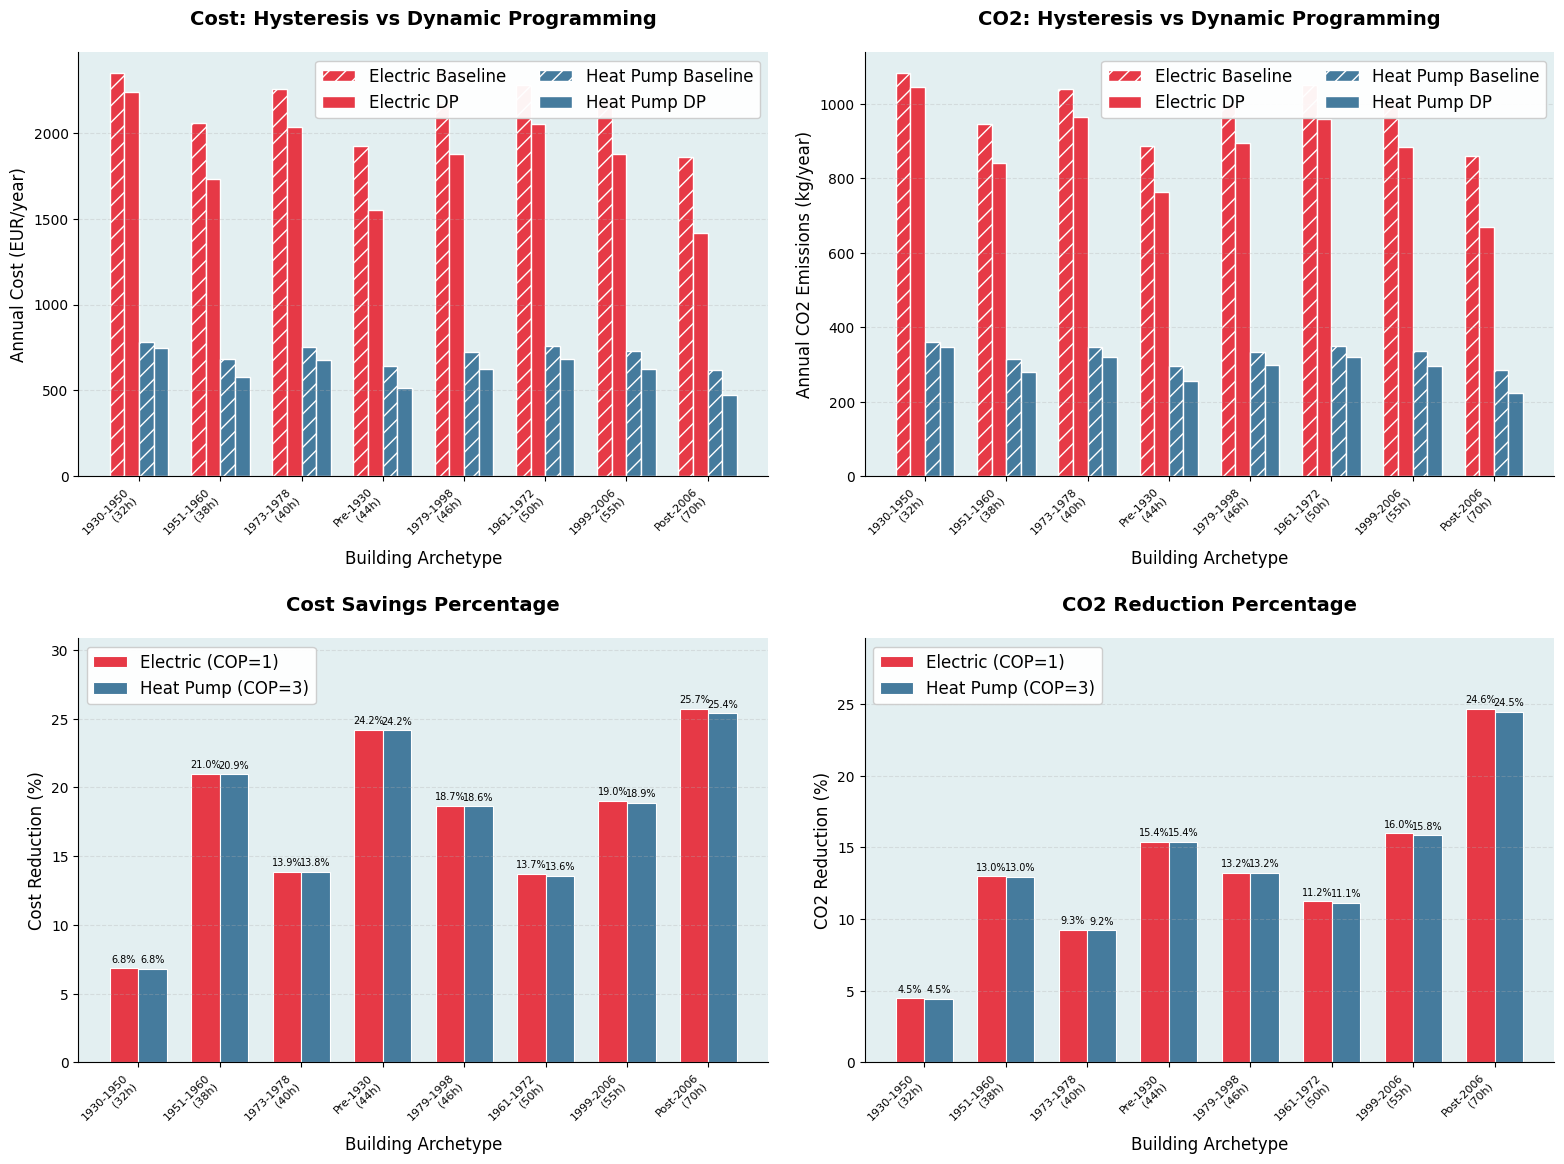

In [31]:
archetype_fig_path = os.path.join(OUTPUT_DIR, "archetype_savings.png")
plot_archetype_savings(national, df_all_results, archetype_fig_path)

# Peak Shift Capabilities

In [32]:
def calculate_national_hourly_profiles(
    daily_data: List[Tuple],
    building_counts: Dict[str, Tuple[int, int]],
) -> Dict[str, np.ndarray]:
    # Accumulate weighted hourly profiles across all archetypes and days
    total_hourly_hyst = np.zeros(24)
    total_hourly_dp = np.zeros(24)
    n_days = len(daily_data)

    for arch in ARCHETYPES:
        electric_count, heatpump_count = building_counts[arch.key]

        for COP, building_count in [
            (COP_ELECTRIC, electric_count),
            (COP_HEATPUMP, heatpump_count),
        ]:
            if building_count == 0:
                continue

            params = create_thermal_params(
                arch.tau_hours, arch.typical_area_m2, COP, P_HEAT_KW
            )

            # Accumulate hourly profiles across all simulation days
            arch_hourly_hyst = np.zeros(24)
            arch_hourly_dp = np.zeros(24)

            for T_outdoor, prices, emissions, _ in daily_data:
                _, _, _, hourly_hyst = simulate_hysteresis(
                    T_outdoor, prices, emissions, params, T_SETPOINT
                )
                _, _, _, hourly_dp = simulate_dp(
                    T_outdoor,
                    prices,
                    emissions,
                    params,
                    T_SETPOINT,
                    T_SETPOINT,
                    T_SETPOINT + 3,
                )
                arch_hourly_hyst += hourly_hyst
                arch_hourly_dp += hourly_dp

            # Average across days, then scale by building count
            arch_hourly_hyst = (arch_hourly_hyst / n_days) * building_count
            arch_hourly_dp = (arch_hourly_dp / n_days) * building_count

            total_hourly_hyst += arch_hourly_hyst
            total_hourly_dp += arch_hourly_dp

    # Convert from kWh to MWh for national scale
    total_hourly_hyst_mwh = total_hourly_hyst / 1000
    total_hourly_dp_mwh = total_hourly_dp / 1000

    return {
        "hourly_hyst_mwh": total_hourly_hyst_mwh,
        "hourly_dp_mwh": total_hourly_dp_mwh,
        "hourly_shift_mwh": total_hourly_hyst_mwh - total_hourly_dp_mwh,
    }


In [33]:
hourly_profiles = calculate_national_hourly_profiles(daily_data, building_counts)

print(
    f"\nTotal daily heating electricity (hysteresis): {hourly_profiles['hourly_hyst_mwh'].sum():.1f} MWh"
)
print(
    f"Total daily heating electricity (DP): {hourly_profiles['hourly_dp_mwh'].sum():.1f} MWh"
)
print(
    f"Peak hourly shift potential: {hourly_profiles['hourly_shift_mwh'].max():.1f} MWh"
)



Total daily heating electricity (hysteresis): 11756.2 MWh
Total daily heating electricity (DP): 12013.1 MWh
Peak hourly shift potential: 112.1 MWh


In [34]:
# Calculate average hourly private consumption profile from the data
# Filter to heating season for consistency with simulation
df_heating_season = df_merged[df_merged["month"].isin(HEATING_MONTHS)].copy()

# Calculate average hourly profiles for private consumption, prices, and emissions
hourly_cons_profile = (
    df_heating_season.groupby("hour")["cons_private_mwh"].mean().values.astype(float)
)
hourly_price_profile = (
    df_heating_season.groupby("hour")["price_eur_kwh"].mean() * 1000
).values.astype(float)  # EUR/MWh
hourly_emissions_profile = (
    df_heating_season.groupby("hour")["co2_g_kwh"].mean().values.astype(float)
)

cons_before = hourly_cons_profile.copy()
cons_after = cons_before - hourly_profiles["hourly_shift_mwh"]
hours = np.arange(24)

print("Average hourly private consumption (heating season):")
print(
    f"  Peak hour: {hours[np.argmax(cons_before)]}:00 with {cons_before.max():.1f} MWh"
)
print(
    f"  After flexibility: {cons_after[np.argmax(cons_before)]:.1f} MWh (reduction: {cons_before.max() - cons_after[np.argmax(cons_before)]:.1f} MWh)"
)
print(
    f"\nPeak shaving potential: {((cons_before.max() - cons_after.max()) / cons_before.max() * 100):.2f}%"
)


Average hourly private consumption (heating season):
  Peak hour: 18:00 with 1687.7 MWh
  After flexibility: 1575.6 MWh (reduction: 112.1 MWh)

Peak shaving potential: 5.13%


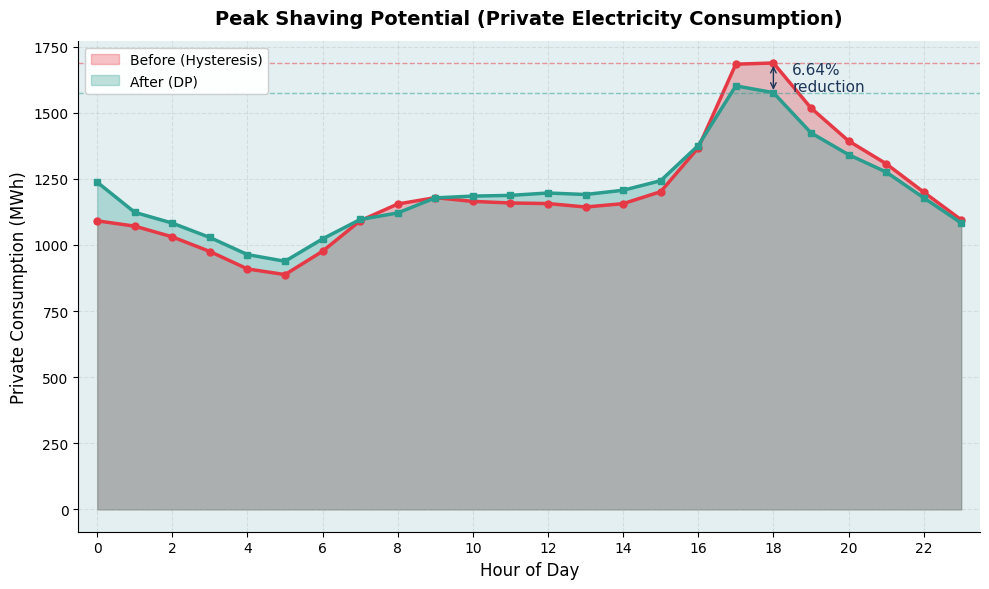

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor(FRAMNA_BACKGROUND)

hours = np.arange(24)
COLOR_BEFORE = "#e63946"
COLOR_AFTER = "#2a9d8f" 

# Plot consumption profiles
ax.fill_between(
    hours, cons_before, alpha=0.3, color=COLOR_BEFORE, label="Before (Hysteresis)"
)
ax.fill_between(
    hours, cons_after, alpha=0.3, color=COLOR_AFTER, label="After (DP)"
)
ax.plot(hours, cons_before, color=COLOR_BEFORE, linewidth=2.5, marker="o", markersize=5)
ax.plot(hours, cons_after, color=COLOR_AFTER, linewidth=2.5, marker="s", markersize=5)

# Find peak hour and calculate reduction
peak_hour = int(np.argmax(cons_before))
peak_before = float(cons_before[peak_hour])
peak_after = float(cons_after[peak_hour])
peak_reduction_pct = (peak_before - peak_after) / peak_before * 100

# Add peak reduction indicator
ax.annotate(
    "",
    xy=(peak_hour, peak_after),
    xytext=(peak_hour, peak_before),
    arrowprops=dict(arrowstyle="<->", color="#1d3557", lw=1),
)

# Add percentage label
mid_y = (peak_before + peak_after) / 2
ax.annotate(
    f"{peak_reduction_pct:.2f}%\nreduction",
    xy=(peak_hour + 0.5, mid_y),
    fontsize=11,
    fontweight="regular",
    color="#1d3557",
    ha="left",
    va="center",
)
# Add horizontal lines at peak values
ax.axhline(y=peak_before, color=COLOR_BEFORE, linestyle="--", alpha=0.5, linewidth=1)
ax.axhline(y=peak_after, color=COLOR_AFTER, linestyle="--", alpha=0.5, linewidth=1)

# Mark the peak points
ax.set_xlabel("Hour of Day", fontsize=12, fontweight="medium")
ax.set_ylabel("Private Consumption (MWh)", fontsize=12, fontweight="medium")
ax.set_title(
    "Peak Shaving Potential (Private Electricity Consumption)",
    fontsize=14,
    fontweight="semibold",
    pad=12,
)
ax.set_xticks(range(0, 24, 2))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc="upper left", fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle="--")
ax.set_facecolor(FRAMNA_BLUE)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, "peak_shaving_potential.png"),
    dpi=200,
    bbox_inches="tight",
    facecolor=FRAMNA_BACKGROUND,
)
plt.show()


In [36]:
# Summary statistics
peak_hour = np.argmax(cons_before)
peak_reduction_mwh = cons_before[peak_hour] - cons_after[peak_hour]
peak_reduction_pct = peak_reduction_mwh / cons_before[peak_hour] * 100

print(f"\nBuildings with flexible heating: {national['total_buildings']:,}")
print(f"- Electric heaters: {national['total_electric']:,}")
print(f"- Heat pumps: {national['total_heatpump']:,}")
print(f"\nPeak hour: {peak_hour}:00")
print(f"- Before: {cons_before[peak_hour]:.1f} MWh")
print(f"- After:  {cons_after[peak_hour]:.1f} MWh")
print(f"- Reduction: {peak_reduction_mwh:.1f} MWh ({peak_reduction_pct:.2f}%)")
print(
    f"\nTotal daily heating load shifted: {np.abs(hourly_profiles['hourly_shift_mwh']).sum() / 2:.1f} MWh"
)
print(f"\nNote: The peak shaving potential is modest because flexible heating")
print(f"represents only a fraction of total private electricity consumption.")



Buildings with flexible heating: 216,791
- Electric heaters: 65,100
- Heat pumps: 151,691

Peak hour: 18:00
- Before: 1687.7 MWh
- After:  1575.6 MWh
- Reduction: 112.1 MWh (6.64%)

Total daily heating load shifted: 567.8 MWh

Note: The peak shaving potential is modest because flexible heating
represents only a fraction of total private electricity consumption.
